In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
portfolio_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

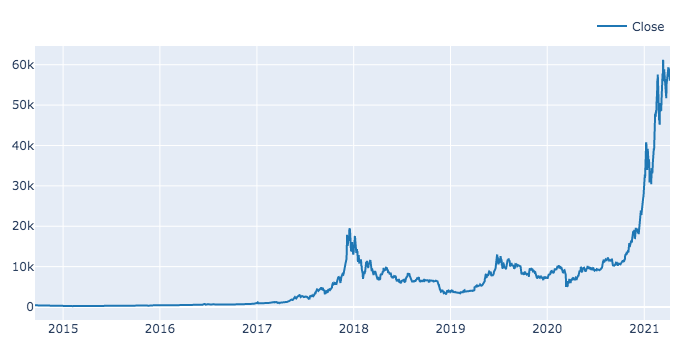

In [4]:
price.vbt.plot().show_png()

In [5]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

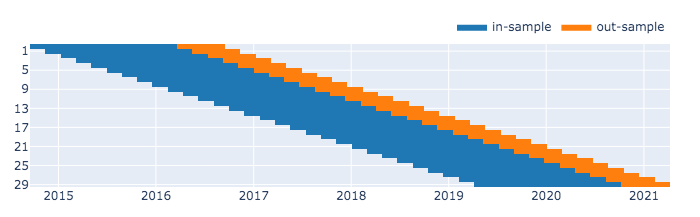

In [6]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_png()

In [7]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [8]:
def simulate_holding(price, **kwargs):
    portfolio = vbt.Portfolio.from_holding(price, **kwargs)
    return portfolio.sharpe_ratio()

In [9]:
in_hold_sharpe = simulate_holding(in_price, **portfolio_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.407739
2     1.238545
3     1.249842
4     1.588366
5     1.904711
6     2.287450
7     2.014816
8     2.312212
9     2.798775
10    2.780599
11    3.149183
12    2.343529
13    2.259943
14    2.097648
15    2.033325
16    1.787817
17    1.242690
18    0.885305
19    0.393669
20    0.310376
21    0.130126
22    0.245234
23    0.368319
24    0.504229
25    0.750594
26    0.484766
27    1.259002
28    1.400597
29    1.058635
Name: sharpe_ratio, dtype: float64


In [27]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()


# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **portfolio_kwargs)

print(in_sharpe)

KeyboardInterrupt: 

In [12]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [13]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (20, 41,  5),
            (41, 42,  6),
            (40, 43,  7),
            (37, 43,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (11, 21, 18),
            (17, 22, 19),
            (17, 22, 20),
            (13, 21, 21),
            (13, 21, 22),
            (18, 21, 23),
            (45, 49, 24),
            (18, 21, 25),
            (13, 21, 26),
            (13, 21, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [14]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [15]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [23 25]
 [20 41]
 [41 42]
 [40 43]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [11 21]
 [17 22]
 [17 22]
 [13 21]
 [13 21]
 [18 21]
 [45 49]
 [18 21]
 [13 21]
 [13 21]
 [13 20]
 [13 20]]


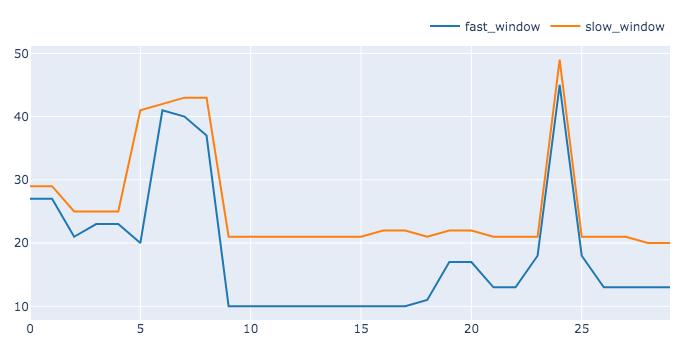

In [16]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_png()

In [17]:
out_hold_sharpe = simulate_holding(out_price, **portfolio_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     2.018748
2     1.755721
3     3.128743
4     2.692203
5     2.913636
6     3.541160
7     3.860226
8     4.300998
9     1.832342
10    0.882911
11   -0.851117
12    0.132318
13    0.192643
14   -2.068312
15   -2.328601
16   -1.382621
17    1.542028
18    3.224538
19    2.850866
20    1.346376
21   -1.245475
22   -0.388867
23   -0.028626
24    1.139813
25    0.934133
26    2.097729
27    3.147384
28    4.211338
29    4.758376
Name: sharpe_ratio, dtype: float64


In [18]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **portfolio_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -1.233168
                          2            1.732389
                          3            0.743637
                          4            1.797290
                                         ...   
48           49           25          -1.147262
                          26          -2.360149
                          27           0.364875
                          28           3.297214
                          29           3.780017
Name: sharpe_ratio, Length: 23400, dtype: float64


In [19]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [20]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **portfolio_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
                      1            0.239573
21         25         2            1.785914
23         25         3            1.979926
                      4            0.605353
20         41         5            1.988868
41         42         6            0.695857
40         43         7           -2.151993
37         43         8            2.073063
10         21         9            3.552332
                      10           2.598022
                      11           0.481991
                      12           1.370560
                      13           0.341544
                      14           0.661940
                      15          -0.230680
           22         16           0.844295
                      17           1.803703
11         21         18           1.845054
17         22         19           0.530590
                      20          -0.615148
13         21         21          -0.938186


In [21]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

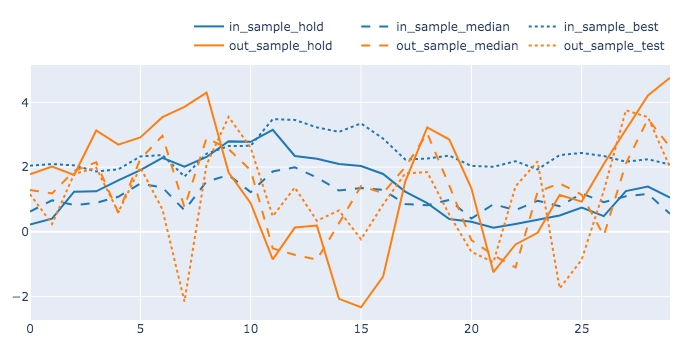

In [22]:
cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=vbt.settings.color_schema['blue']),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dot'),
        dict(line_color=vbt.settings.color_schema['orange']),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dot')
    ]
).show_png()


